In [4]:
from tensorflow.keras import layers, models

#AE모델링
class AE(models.Model):
    #생성자 x_nodes 입력노드수, z_dim 은닉노드수
    # 24 x 24(픽셀 784개) 입력 이미지들이 원소 36개로 구성된 벡터로 변환된 뒤
    # 24 x 24 이미지로 복구됨
    def __init__(self, x_nodes=784, z_dim=36):
        x_shape = (x_nodes,)
        #입력계층
        x = layers.Input(shape=x_shape)
        #은닉계층
        z = layers.Dense(z_dim, activation='relu')(x)
        #출력계층
        y = layers.Dense(x_nodes, activation='sigmoid')(z)
        super().__init__(x,y)
        self.x = x
        self.z = z
        self.z_dim = z_dim

        self.compile(optimizer='adam',
        loss='binary_crossentropy', metrics=['accuracy'])

    #신경망 외부에서 부호화 결과를 입력하고 싶을 때 호출할 함수
    def Encoder(self):
        return models.Model(self.x, self.z)

    #복호화를 수행하는 함수
    def Decoder(self):
        z_shape = (self.z_dim,)
        z = layers.Input(shape=z_shape)
        #제일 마지막 레이어가 출력 계층
        y_layer = self.layers[-1]
        y = y_layer(z)
        return models.Model(z, y)

In [5]:
from tensorflow.keras.datasets import mnist
import numpy as np

#데이터 로딩
#레이블 정보는 _로 전달받음, 추후 사용되지 않는
# 함수의 리턴값을 받는 변수는 밑줄(_) 사용을 권장함
# AE는 비지도 학습이기에 레이블을 필요로 하지 않음
#입력데이터를 출력데이터에 똑같이 사용함
(X_train, _), (X_test, _) = mnist.load_data()

#입력값이 1 이하가 되도록 정규화시킴
X_train = X_train.astype('float32') / 255.
X_test = X_test.astype('float32') / 255.
print(X_test.shape)

#3차원에서 2차원 형태로 모양을 바꿈(차원 축소)
#len(X_train) 이미지수, np.prod(X_train.shape[1:]) 이미지 길이
#print(X_train.shape[1:]) #(28,28)
X_train = X_train.reshape(len(X_train), 784)
X_test = X_test.reshape(len(X_test), 784)
print(X_train.shape)
print(X_test.shape)

(10000, 28, 28)
(60000, 784)
(10000, 784)


In [6]:
#피라미터 설정(입력노드수 784, 부호화 벡터 길어 36 - 
# 길이가 784인 원래 이미지의 데이터 길이가 36으로 압축됨)

x_nodes = 784
z_dim = 36

#모델 생성
autoencoder = AE(x_nodes, z_dim)

#모델 학습
#입력데이터와 출력데이터를 동일하게 설정
#fit(입력데이터, 출력데이터)
history = autoencoder.fit(X_train, X_train, epochs=5, batch_size=256, validation_split=0.2)


Epoch 1/5
188/188 [==============================] - 1s 3ms/step - loss: 0.3997 - accuracy: 0.0083 - val_loss: 0.1966 - val_accuracy: 0.0095
Epoch 2/5
188/188 [==============================] - 0s 2ms/step - loss: 0.1852 - accuracy: 0.0119 - val_loss: 0.1594 - val_accuracy: 0.0103
Epoch 3/5
188/188 [==============================] - 0s 2ms/step - loss: 0.1548 - accuracy: 0.0103 - val_loss: 0.1406 - val_accuracy: 0.0108
Epoch 4/5
188/188 [==============================] - 0s 2ms/step - loss: 0.1378 - accuracy: 0.0098 - val_loss: 0.1285 - val_accuracy: 0.0103
Epoch 5/5
188/188 [==============================] - 0s 2ms/step - loss: 0.1258 - accuracy: 0.0104 - val_loss: 0.1188 - val_accuracy: 0.0109


In [9]:
import matplotlib.pyplot as plt

def plot_acc(history, title=None):
    if not isinstance(history, dict):
        history = history.history
    plt.plot(history['accuracy'])
    plt.plot(history['val_accuracy'])
    if title is not None:
        plt.title(title)
    plt.ylabel('정확도')
    plt.xlabel('에포크')
    plt.legend(['학습 데이터 성능', '검증 데이터 성능'], loc=0)

def plot_loss(history, title=None):
    if not isinstance(history, dict):
        history = history.history
    plt.plot(history['loss'])
    plt.plot(history['val_loss'])
    if title is not None:
        plt.title(title)
    plt.ylabel('손실')
    plt.xlabel('에포크')
    plt.legend(['학습 데이터 성능', '검증 데이터 성능'], loc=0)

def plot_loss_acc(history):
    plot_loss(history, '손실 추이')
    plt.show()
    plot_acc(history, '정확도 추이')
    plt.show()

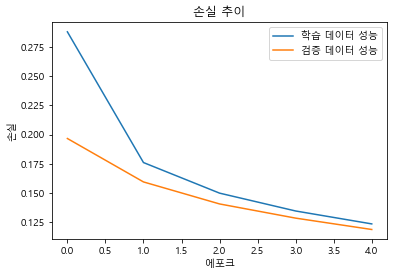

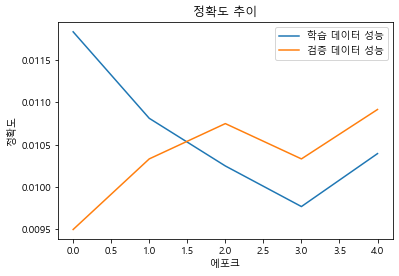

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc

font_location = 'c:/windows/fonts/malgun.ttf'
font_name = font_manager.FontProperties(fname=font_location).get_name()
rc('font', family = font_name)

#플로팅
plot_loss_acc(history)
#손실값: 부호화 후 복호화한 이미지와 원 이미지가 얼마나 유사한지를 나타냄,
# 손실값이 작을수록 부호화가 잘된 것
# 입력데이터(학습에 사용되지 않은 숫자 이미지)
# 부호화 결과
# 출력이미지

In [13]:
# AE 동작 확인
def show_ae(autoencoder):
    #부호화, 복호화 모델의 인스턴스 생성
    encoder = autoencoder.Encoder()
    decoder = autoencoder.Decoder()

    #평가용 이미지들을 넣어서 부호화 결과와 복호화 결과 생성
    encoded_imgs = encoder.predict(X_test)
    #부호화된 이미지를 넣어서 복호화 데이터를 생성함
    decoded_imgs = decoder.predict(encoded_imgs)
    #화면에 표시할 이미지 수
    n = 10
    #subplot 방식을 사용하여 10개를 하나의 그래프로 그리기 위해 
    # 그림의 전체 크기를 20, 6으로 설정
    plt.figure(figsize=(20,6))
    for i in range(n):
        ax = plt.subplot(3, n, i + 1)
        #입력 이미지(평가용 이미지)
        plt.imshow(X_test[i].reshape(28,28))
        #흑백으로 출력
        plt.gray()
        #이미지 주변 축들이 보이지 않게 함
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        ax = plt.subplot(3, n, i + 1 + n)
        #이미지가 압축된 형태(2차원 이미지를 1차원의 벡터로 압축)
        plt.stem(encoded_imgs[i].reshape(-1))
        plt.gray()
        #이미지 주변 축들이 보이지 않게 함
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        ax = plt.subplot(3, n, i + 1 + n)
        
        #이미지가 압축된 형태(2차원 이미지를 1차원의 벡터로 압축)
        plt.stem(encoded_imgs[i].reshape(-1))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        ax = plt.subplot(3, n, i + 1 + n + n)

        #복호화한 이미지 출력
        plt.imshow(decoded_imgs[i].reshape(28,28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

<ipython-input-13-3a536d885115>:32: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.subplot(3, n, i + 1 + n)
<ipython-input-13-3a536d885115>:32: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.subplot(3, n, i + 1 + n)
<ipython-input-13-3a536d885115>:32: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance

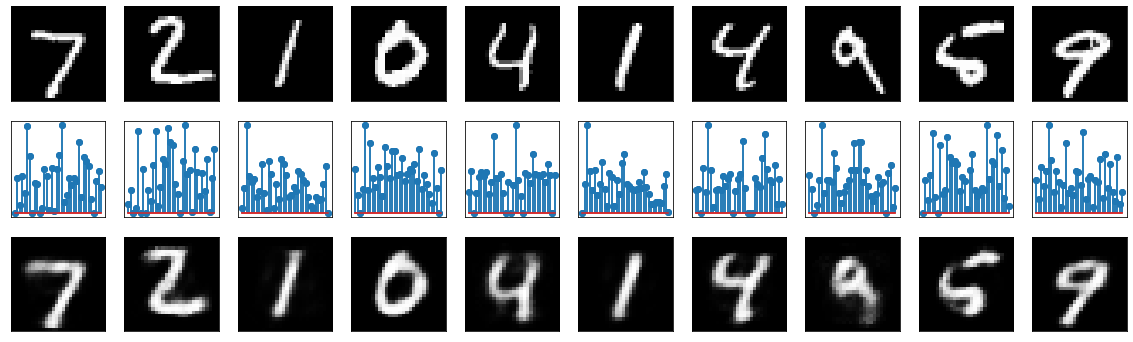

In [14]:
show_ae(autoencoder)